# Simple Monte Carlo Inference of Foreground Halo Masses

##### David Thomas, SLAC 2016

In this notebook we infer the halo masses a small number of individual halos in front of a tiny patch of background, weakly-lensed galaxies. First we explore the probabilistic graphical model (PGM) for this simple inference, and then we use Simple Monte Carlo sampling to characterize the halo mass posterior PDFs.

### Requirements

To run this notebook, you will need the `daft` package installed:
```
pip install daft
```

## The PGM
For more an introduction to PGMS see Daphne Koller's [Probabilistic Graphical Models](http://pgm.stanford.edu/). Below is the PGM that we will explore in this notebook.

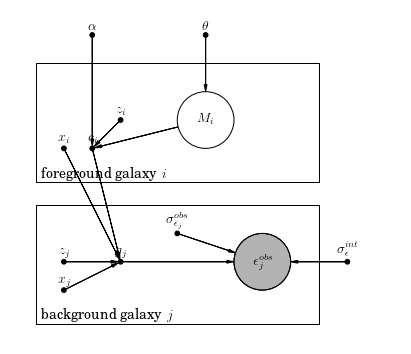

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

from matplotlib import rc
rc("font", family="serif", size=14)
rc("text", usetex=True)

import daft

pgm = daft.PGM([7, 6], origin=[0, 0])

#background nodes
pgm.add_plate(daft.Plate([0.5, 3.0, 5, 2], label=r"foreground galaxy $i$",
    shift=-0.1))
pgm.add_node(daft.Node("theta", r"$\theta$", 3.5, 5.5, fixed=True))
pgm.add_node(daft.Node("alpha", r"$\alpha$", 1.5, 5.5, fixed=True))
pgm.add_node(daft.Node("halo_mass", r"$M_i$", 3.5, 4, scale=2))
pgm.add_node(daft.Node("background_z", r"$z_i$", 2, 4, fixed=True))
pgm.add_node(daft.Node("concentration", r"$c_i$", 1.5, 3.5, fixed=True))
pgm.add_node(daft.Node("background_x", r"$x_i$", 1.0, 3.5, fixed=True))

#foreground nodes
pgm.add_plate(daft.Plate([0.5, 0.5, 5, 2], label=r"background galaxy $j$",
    shift=-0.1))
pgm.add_node(daft.Node("reduced_shear", r"$g_j$", 2.0, 1.5, fixed=True))
pgm.add_node(daft.Node("reduced_shear", r"$g_j$", 2.0, 1.5, fixed=True))
pgm.add_node(daft.Node("foreground_z", r"$z_j$", 1.0, 1.5, fixed=True))
pgm.add_node(daft.Node("foreground_x", r"$x_j$", 1.0, 1.0, fixed=True))
pgm.add_node(daft.Node("ellipticities", r"$\epsilon_j^{obs}$", 4.5, 1.5, observed=True, scale=2))

#outer nodes
pgm.add_node(daft.Node("sigma_obs", r"$\sigma_{\epsilon_j}^{obs}$", 3.0, 2.0, fixed=True))
pgm.add_node(daft.Node("sigma_int", r"$\sigma_{\epsilon}^{int}$", 6.0, 1.5, fixed=True))

#edges
pgm.add_edge("foreground_z", "reduced_shear")
pgm.add_edge("foreground_x", "reduced_shear")
pgm.add_edge("reduced_shear", "ellipticities")
pgm.add_edge("sigma_obs", "ellipticities")
pgm.add_edge("sigma_int", "ellipticities")
pgm.add_edge("concentration", "reduced_shear")
pgm.add_edge("halo_mass", "concentration")
pgm.add_edge("background_z", "concentration")
pgm.add_edge("background_x", "reduced_shear")
pgm.add_edge("alpha", "concentration")
pgm.add_edge("theta", "halo_mass")
pgm.render()

We have sets of foregrounds and backgrounds along with the variables

- $\alpha$:  parameters in the concentration function (which is a function of $z_i,M_i$)
- $\theta$: prior distribution of halo masses
- $z_i$: foreground galaxy redshift
- $x_i$: foreground galaxy angular coordinates
- $z_j$: background galaxy redshift
- $x_j$: background galaxy angular coordinates
- $g_j$: reduced shear
- $\sigma_{\epsilon_j}^{obs}$: noise from our ellipticity measurement process
- $\sigma_{\epsilon}^{int}$: intrinsic variance in ellipticities
- $\epsilon_j^{obs}$: intrinsic variance in ellipticities

## Inference

We use the Simple Monte Carlo to generate many samples from the posterior PDF for $M$:
```
1. Draw prior samples
2. Compute log likelihood
3. Renormalize and exponentiate log likelihood values and assign to samples as importance weights
4. Compute integral inferences as weighted sums over the samples
```

In [2]:
from pangloss import data, BackgroundCatalog, Configuration, ForegroundCatalog, \
    TrueHaloMassDistribution
from pandas import DataFrame

# initialize background and foreground
B = BackgroundCatalog(N=10.0, domain=[1.43, 1.4, -1.43, -1.4], field=[0, 0, 0, 0])
config = Configuration.example()
F = ForegroundCatalog(data.guo_file, config)
F.set_mass_prior(TrueHaloMassDistribution()) # This needs explaining...

# lens the background galaxies with the model halos - i.e., this notebook is a functional test!
B.lens_by_halos(relevance_lim=0.00001, lookup_table=True, smooth_corr=True)

['/Users/pjm/work/stronglensing/H0/lightcones/Pangloss/calib/Millennium/catalog_example.txt']
['/Users/pjm/work/stronglensing/H0/lightcones/Pangloss/calib/Millennium/GGL_los*.fits']


IndexError: list index out of range

In [ ]:
# run monte carlo samples
output = DataFrame()
for _ in range(5):
    F.draw_halo_masses()
    B.drill_lightcones(radius=1.0, foreground=F, save=False, smooth_corr=True)
    B.lens_by_halos(relevance_lim=0.00001, lookup_table=True, smooth_corr=True)
    halos = B.get_sampled_halo_masses_in_lightcones()
    halos['log-likelihood'] = B.calculate_log_likelihood()
    output = output.append(halos, ignore_index=True)

# galaxies that were filtered due to relevance should be assigned mass of 0
output = output.fillna(0)
output

In [ ]:
B.get_true_halo_masses_in_lightcones()

## Performance Benchmark

coming soon ...